This notebook is for demonstrating how to use a trained PM2.5 prediction model to make predictions on a target area.

# Imports

In [67]:
%load_ext autoreload 
%autoreload 2

import geopandas as gpd
import re

import joblib
import numpy as np
import pandas as pd

import sys
sys.path.append("../../")

from src.config import settings
from src.data_processing import feature_collection_pipeline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Parameters

In [68]:

# CSV file for target roll-out location
# CENTROIDS_PATH = "data/mueang_chiang_mai_tile_centroids.csv"
CENTROIDS_PATH = "data/mueang_phuket_tile_centroids.csv"


# ID Column in the target CSV file
ID_COL = "id"

# Desired date range
START_DATE = "2019-03-01"
END_DATE = "2019-03-31"
# Model being used was trained using 1km x 1km bounding box
BBOX_SIZE_KM = 1

# Path to the model to be used for prediction
MODEL_PATH = settings.DATA_DIR / "latest_model.pkl"

# Path to the population raster (In our study, we're using the Thai 2020 HRSL raster)
HRSL_TIF = settings.DATA_DIR / "tha_general_2020.tif"

# Where to save the model predictions of  daily PM2.5 levels
OUTPUT_PREDICTIONS_FILE = "data/phuket_march2019_predictions.csv"

# What to name the column for predictions
PRED_COL = "predicted_pm2.5"

# Load Area of Interest

In [69]:
def extract_lon_lat(wkt_string_point):
    regex = r'[0-9-\.]+'
    parsed_geom = re.findall(regex, wkt_string_point)
    parsed_geom = [float(i) for i in parsed_geom]
    assert len(parsed_geom) == 2
    return parsed_geom[0], parsed_geom[1]


def load_centroids(centroids_path):
    locations_gdf = gpd.read_file(centroids_path)
    all_lon_lat = locations_gdf["WKT"].apply(lambda x: extract_lon_lat(x)).tolist()
    all_lon, all_lat = zip(*all_lon_lat)

    locations_gdf["longitude"] = all_lon
    locations_gdf["latitude"] = all_lat 

    locations_df = pd.DataFrame(locations_gdf)
    locations_df.drop(["geometry", "WKT"], axis=1, inplace=True)

    return locations_df
    

In [70]:
locations_df = load_centroids(CENTROIDS_PATH)[:]
len(locations_df)

192

In [71]:
locations_df.columns

Index(['id', 'left', 'top', 'right', 'bottom', 'Shape_Leng', 'Shape_Area',
       'ADM3_EN', 'ADM3_TH', 'ADM3_PCODE', 'ADM3_REF', 'ADM3ALT1EN',
       'ADM3ALT2EN', 'ADM3ALT1TH', 'ADM3ALT2TH', 'ADM2_EN', 'ADM2_TH',
       'ADM2_PCODE', 'ADM1_EN', 'ADM1_TH', 'ADM1_PCODE', 'ADM0_EN', 'ADM0_TH',
       'ADM0_PCODE', 'date', 'validOn', 'validTo', 'longitude', 'latitude'],
      dtype='object')

# Predict

## Collect Features

In [72]:
# Create base DF from the locations (collect the necessary features)
base_df = feature_collection_pipeline.collect_features_for_locations(
    locations_df=locations_df,
    start_date=START_DATE,
    end_date=END_DATE,
    id_col=ID_COL,
    hrsl_tif=HRSL_TIF,
    bbox_size_km=BBOX_SIZE_KM,
    # Customized the list of GEE datasets because the latest model doesn't use MAIAC
    gee_datasets=[
        feature_collection_pipeline.S5P_AAI_CONFIG,
        feature_collection_pipeline.CAMS_AOD_CONFIG,
        feature_collection_pipeline.NDVI_CONFIG,
        feature_collection_pipeline.ERA5_CONFIG,
    ],
)


2022-05-18 01:57:13.722 | INFO     | src.data_processing.feature_collection_pipeline:collect_features_for_locations:86 - Authenticating with GEE...
2022-05-18 01:57:16.819 | INFO     | src.data_processing.feature_collection_pipeline:collect_features_for_locations:90 - Computing population sums...
2022-05-18 01:57:19.556 | INFO     | src.data_processing.feature_collection_pipeline:collect_features_for_locations:96 - Collecting GEE datasets...
2022-05-18 01:57:19.557 | INFO     | src.data_processing.feature_collection_pipeline:collect_gee_datasets:152 - Collecting GEE data (1 / 4): {'collection_id': 'COPERNICUS/S5P/OFFL/L3_AER_AI', 'bands': ['absorbing_aerosol_index'], 'preprocessors': [<function aggregate_daily_s5p_aerosol at 0x7fa19a5284d0>]}


{'collection_id': 'COPERNICUS/S5P/OFFL/L3_AER_AI', 'bands': ['absorbing_aerosol_index'], 'preprocessors': [<function aggregate_daily_s5p_aerosol at 0x7fa19a5284d0>]}


  0%|          | 0/192 [00:00<?, ?it/s]

2022-05-18 01:59:01.450 | INFO     | src.data_processing.feature_collection_pipeline:collect_gee_datasets:152 - Collecting GEE data (2 / 4): {'collection_id': 'ECMWF/CAMS/NRT', 'bands': ['total_aerosol_optical_depth_at_550nm_surface'], 'preprocessors': [<function rescale_cams_aod at 0x7fa19a5283b0>, <function aggregate_daily_cams_aod at 0x7fa19a528440>]}


{'collection_id': 'ECMWF/CAMS/NRT', 'bands': ['total_aerosol_optical_depth_at_550nm_surface'], 'preprocessors': [<function rescale_cams_aod at 0x7fa19a5283b0>, <function aggregate_daily_cams_aod at 0x7fa19a528440>]}


  0%|          | 0/192 [00:00<?, ?it/s]

2022-05-18 02:01:24.156 | INFO     | src.data_processing.feature_collection_pipeline:collect_gee_datasets:152 - Collecting GEE data (3 / 4): {'collection_id': 'MODIS/006/MOD13A2', 'bands': ['NDVI', 'EVI'], 'preprocessors': [<function aggregate_daily_ndvi at 0x7fa19962cc20>]}


{'collection_id': 'MODIS/006/MOD13A2', 'bands': ['NDVI', 'EVI'], 'preprocessors': [<function aggregate_daily_ndvi at 0x7fa19962cc20>]}


  0%|          | 0/192 [00:00<?, ?it/s]

2022-05-18 02:02:43.601 | INFO     | src.data_processing.feature_collection_pipeline:collect_gee_datasets:152 - Collecting GEE data (4 / 4): {'collection_id': 'ECMWF/ERA5_LAND/HOURLY', 'bands': ['dewpoint_temperature_2m', 'temperature_2m', 'total_precipitation_hourly', 'u_component_of_wind_10m', 'v_component_of_wind_10m', 'surface_pressure'], 'preprocessors': [<function aggregate_daily_era5 at 0x7fa19a528320>]}


{'collection_id': 'ECMWF/ERA5_LAND/HOURLY', 'bands': ['dewpoint_temperature_2m', 'temperature_2m', 'total_precipitation_hourly', 'u_component_of_wind_10m', 'v_component_of_wind_10m', 'surface_pressure'], 'preprocessors': [<function aggregate_daily_era5 at 0x7fa19a528320>]}


  0%|          | 0/192 [00:00<?, ?it/s]

In [73]:
# Load Model
model = joblib.load(MODEL_PATH)

# Filter to only the relevant columns
keep_cols = model.feature_names  # This was saved from the train script
ml_df = base_df[keep_cols]

# Run model
preds = model.predict(ml_df)
base_df[PRED_COL] = preds
base_df.to_csv(OUTPUT_PREDICTIONS_FILE, index=False)


# Quick checks on predictions

We print out quick summary stats and plot the histogram of predicted pm2.5 values for the district of Chiang Mai and Phuket. 

It was known that Chiang Mai in March 2019 had poor air quality due to burning season. 

On the other hand, we expect the air at Phuket to be cleaner since it is far away from agricultural lands that are burned.

Min:24.05 - Max:165.48; Mean=81.61


<AxesSubplot:>

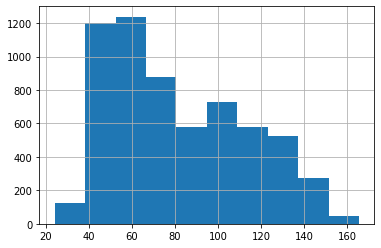

In [80]:
# Check predictions for Chiang Mai in March 2019

results_df = pd.read_csv("data/chiang_mai_march2019_predictions.csv")
results_df = gpd.GeoDataFrame(results_df, geometry=gpd.points_from_xy(results_df.longitude, results_df.latitude))
preds = results_df[PRED_COL]
print(f"Min:{min(preds):.2f} - Max:{max(preds):.2f}; Mean={np.mean(preds):.2f}")
results_df[PRED_COL].hist()

Min:-1.79 - Max:119.45; Mean=32.73


<AxesSubplot:>

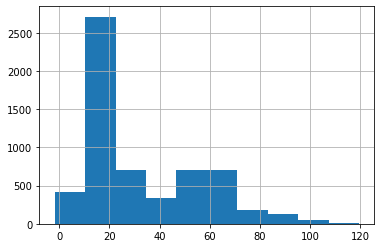

In [81]:
# Check predictions for Phuket in March 2019

results_df = pd.read_csv("data/phuket_march2019_predictions.csv")
results_df = gpd.GeoDataFrame(results_df, geometry=gpd.points_from_xy(results_df.longitude, results_df.latitude))
preds = results_df[PRED_COL]
print(f"Min:{min(preds):.2f} - Max:{max(preds):.2f}; Mean={np.mean(preds):.2f}")
results_df[PRED_COL].hist()